In [1]:
# Autoload when refreshing notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter
from scipy.optimize import curve_fit

# import Python functions 
import sys
sys.path.append('../../')

from Python_Functions.functions import cropProfmonImg, matstruct_to_dict, extractDAQBSAScalars, segment_centroids_and_com, plot2DbunchseparationVsCollimatorAndBLEN, extract_processed_images, apply_centroid_correction, apply_tcav_zeroing_filter, find_experiment_file
from Python_Functions.gmm import image_to_bigaussian_params, unflatten_biGaussian_params, gaussian_2d_pdf, is_valid_biGaussian_params, flatten_biGaussian_params

In [2]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um

# Sets the main beam energy
mainbeamE_eV = 10e9
# Sets the dnom value for CHER
dnom = 59.8e-3

# Sets data location
experiment = 'E327' #'E300' 'E338'
runname = '14301' #'12431' '12710'
base_path = '/nas/nas-li20-pm00/' # Only works on the control system facet-srv20. '../../data/raw/' if running locally with downloaded data.
step_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14] # steps to process, starting from 1
## Below value MUST be specified for DAQs with unwanted refraction patterns, etc.
roi_xrange = None#For run 12710: (400, 700)
roi_yrange = None#For run 12710: (400, 600), 12691: (0, 236)

In [3]:
# Loads dataset
dataloc = find_experiment_file(experiment, runname, base_path)
directory_path = dataloc.parent
mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
data_struct = mat['data_struct']

# Extracts number of steps
stepsAll = data_struct.params.stepsAll
if stepsAll is None or len(np.atleast_1d(stepsAll)) == 0:
    stepsAll = [1]

# calculate xt calibration factor
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8

# cropping aspect ratio 
xrange = 100 
yrange = 100


# gaussian filter parameter
hotPixThreshold = 1e3
sigma = 1
threshold = 5

Searching in: /nas/nas-li20-pm00/E327


Processing steps: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Applying filter: Setting 742 samples of TCAV_LI20_2400_P to 0 where TCAV_LI20_2400_A < 1.0
Extracted BSA scalar data shape: (138, 2197)


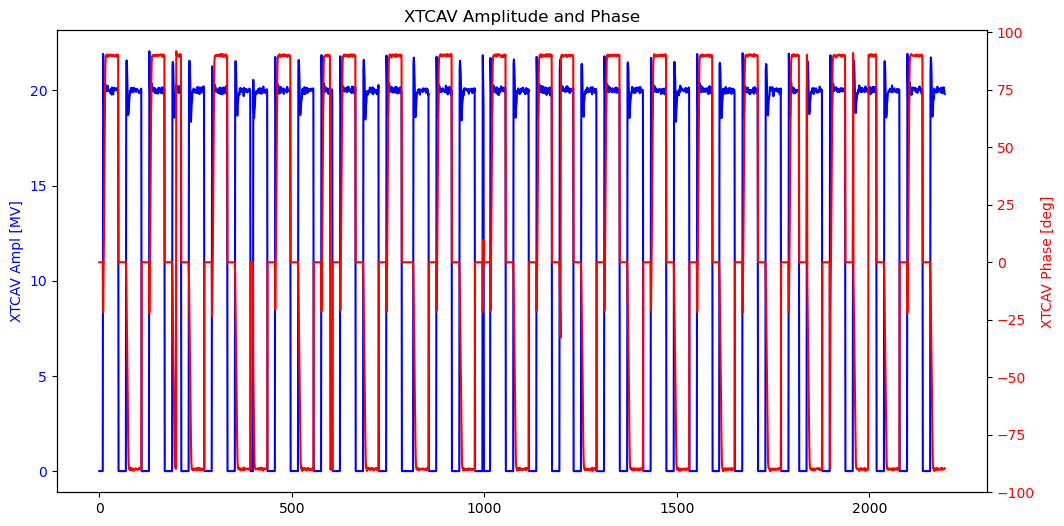

In [4]:
print("Processing steps:", step_list)
bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct, step_list)
bsaScalarData = apply_tcav_zeroing_filter(bsaScalarData, bsaVars)
print("Extracted BSA scalar data shape:", bsaScalarData.shape)
ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = bsaScalarData[ampl_idx, :]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = bsaScalarData[phase_idx, :]

xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting

isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(isChargePV) if val]
charge = bsaScalarData[pvidx, :] * 1.6e-19  # in C 

minus_90_idx = np.where((xtcavPhase >= -91) & (xtcavPhase <= -89))[0]
plus_90_idx = np.where((xtcavPhase >= 89) & (xtcavPhase <= 91))[0]
off_idx = np.where(xtcavPhase == 0)[0]
all_idx = np.append(minus_90_idx,plus_90_idx)

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(xtcavAmpl, label='Amplitude', color='b')
ax1.set_ylabel('XTCAV Ampl [MV]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(xtcavPhase, label='Phase', color='r')
ax2.set_ylabel('XTCAV Phase [deg]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('XTCAV Amplitude and Phase')
plt.show()



### Common Index Debugging

i th image can be found at images.instrument_name.common_index[i] of the file images.instrument_name.loc


The corresponding i th scalar is at scalars.bsa_name[scalars.common_index[i]]

In [5]:

# Define the interval for inspection
STEP_SIZE = 1
START = 590
END = 610

# Extract the arrays
dtotr2_data = data_struct.images.DTOTR2.common_index
scalars_data = data_struct.scalars.common_index
step_data = data_struct.scalars.steps[scalars_data]

# 1. Get the indices for every Nth row (e.g., 0, 50, 100, ...)
all_indices = np.arange(len(dtotr2_data))
filtered_indices = all_indices[START:END:STEP_SIZE]

# 2. Filter the data arrays using the selected indices
filtered_dtotr2 = dtotr2_data[START:END:STEP_SIZE]
filtered_scalars = scalars_data[START:END:STEP_SIZE]
filtered_steps = step_data[START:END:STEP_SIZE]

# 3. Create a pandas DataFrame for structured output
data = {
    f'Row Index (Every {STEP_SIZE}th)': filtered_indices,
    'DTOTR2 Common Index': filtered_dtotr2,
    'Scalars Common Index': filtered_scalars,
    # Optional: Calculate the difference between the two indices
    'Scalar Step': filtered_steps
}

comparison_df = pd.DataFrame(data)

# --- Print the Comparison Table ---
print(f"--- Comparison of Common Indices (Every {STEP_SIZE}th Row) ---\n")

# Configure pandas to display all rows and columns without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) # Set a reasonable width for display

# Print the comparison table
print(comparison_df)

# Reset display options (optional, good practice)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

--- Comparison of Common Indices (Every 1th Row) ---

    Row Index (Every 1th)  DTOTR2 Common Index  Scalars Common Index  Scalar Step
0                     590                  591                   592            3
1                     591                  592                   593            3
2                     592                  593                   594            3
3                     593                  594                   595            3
4                     594                  595                   596            3
5                     595                  596                   597            3
6                     596                  597                   598            3
7                     597                  598                   599            3
8                     598                  599                   600            3
9                     599                  600                   601            3
10                    600                  6

In [9]:
# Extract current profiles and 2D LPS images 
xtcavImages_list = []
xtcavImages_list_raw = []
horz_proj_list = []
LPSImage = [] 
xtcavImages_centroid_uncorrected, xtcavImages_raw, horz_proj, LPSImage = extract_processed_images(data_struct, experiment, xrange, yrange, hotPixThreshold, sigma, threshold, step_list, roi_xrange, roi_yrange, do_load_raw=False, directory_path=directory_path)# do_load_raw = False by default.
print(LPSImage.shape)


Processing Shots Step 14, 200 samples: 100%|██| 200/200 [00:02<00:00, 75.49it/s]


Processed XTCAV Images shape: (200, 200, 2203)
StepsToProcess:[np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(14)]
(2197, 40000)


###  Centroid Correction (Optional)

In [12]:
xtcavImages, horz_proj, LPSImage, centroid_corrections = apply_centroid_correction(xtcavImages_centroid_uncorrected, off_idx)
print(LPSImage.shape)

Corrected N_shots: 2197
(2197, 40000)


### Current Profile Generation

### Check Images

In [13]:
from ipywidgets import interact, IntSlider, Layout
# Find the first shot where tcav is at -90, 0 and +90 deg
def plot_sample_images(idx):
    near_minus_90_idx = minus_90_idx[idx]
    near_plus_90_idx = plus_90_idx[idx]
    zero_idx = off_idx[idx]

    sample_image_indices = [near_minus_90_idx, zero_idx, near_plus_90_idx]
    plot_titles = ['Tcav phase -90 deg', '0 deg', '+90 deg']


    # Define the x and yrange for cropping the image; Need to automate this
    # figure;imagesc(sampleImage)

    xrange = 100
    yrange = xrange

    if xtcavImages_raw is not None:
        fig, axs = plt.subplots(1, 4, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})
        fig.suptitle(f'TCAV images RAW DAQ {experiment} - {runname}', fontsize=14)

        for i, idx in enumerate(sample_image_indices):
            if idx is None:
                continue

            sample_image = xtcavImages_raw[:, :, idx]

            axs[i].imshow(sample_image, cmap='jet', aspect='auto')
            axs[i].set_title(plot_titles[i])

        # Colorbar, top right corner, horizontal
        cbar = fig.colorbar(axs[2].images[0], cax = axs[3], orientation='vertical', fraction=0.05, pad=0.2)
        cbar.set_label('Intensity [a.u.]')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("Raw images not loaded. Set do_load_raw=True in extract_processed_images to load raw images.")

    fig, axs = plt.subplots(2, 3, figsize=(12, 6))
    fig.suptitle(f'TCAV images before centroid correction DAQ {experiment} - {runname}', fontsize=14)

    for i, idx in enumerate(sample_image_indices):
        if idx is None:
            continue

        sample_image = xtcavImages_centroid_uncorrected[:, :, idx]
        horz_proj = np.sum(sample_image, axis=0)

        axs[0, i].imshow(sample_image, cmap='jet', aspect='auto')
        axs[0, i].set_title(plot_titles[i])

        axs[1, i].plot(horz_proj)
        axs[1, i].set_title("Horizontal Projection")
        #If i==1, the center plot, also plot centroid_corrections on the 2d image
        if i==1:
            for row in range(sample_image.shape[0]):
                shift = centroid_corrections[row]
                # Plot a dot at (shift, row)
                axs[0, i].plot(xrange - shift, row, 'wo', markersize=1)

            # Draw a vertical line at the center of mass x
            center_of_mass_x = np.sum(horz_proj * np.arange(horz_proj.shape[0])) / np.sum(horz_proj)
            axs[0, i].axvline(center_of_mass_x, color='w', linestyle='--')
        
        # Print image common index
        axs[0, i].text(0.5, -0.2, f'index {idx}', ha='center', va='center', transform=axs[0, i].transAxes)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    fig, axs = plt.subplots(2, 3, figsize=(12, 6))
    fig.suptitle(f'TCAV images after centroid correction DAQ {experiment} - {runname}', fontsize=14)

    for i, idx in enumerate(sample_image_indices):
        if idx is None:
            continue

        sample_image = xtcavImages[:, :, idx]
        horz_proj = np.sum(sample_image, axis=0)

        axs[0, i].imshow(sample_image, cmap='jet', aspect='auto')
        axs[0, i].set_title(plot_titles[i])

        axs[1, i].plot(horz_proj)
        axs[1, i].set_title("Horizontal Projection")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
interact(plot_sample_images, idx=IntSlider(min=0, max=off_idx.size, step=1, value=0, layout=Layout(width='80%')))

interactive(children=(IntSlider(value=0, description='idx', layout=Layout(width='80%'), max=742), Output()), _…

<function __main__.plot_sample_images(idx)>

### Filter Good Shots

In [11]:
# Plot some good shots xtcavOffShots
def plot_goodshot_sample_images(idx):
    image_to_bigaussian_params(xtcavImages[:,:,idx], do_current_profile=True, debug = True)
interact(plot_goodshot_sample_images, idx=IntSlider(min=0, max=xtcavImages.shape[2]-1, step=1, value=0, layout=Layout(width='80%')))

NameError: name 'xtcavImages' is not defined

In [ ]:
# Filter out "bad" shots with Bi-Gaussian fit 
def bi_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

amp1 = []
amp2 = []
mu1 = []
mu2 = []
R_squared = []
#This is 1 based indexing from matlab!!!
scalar_common_idx = []

# At this point, xtcavImage, currentProfile, LPSImage are already filtered with image common index, hence they are dense from 0 to N-(some lost images).
# bsaScalarData and xtcavPhase are filtered with scalar common index too, so xtcavImage[i] corresponds to bsaScalarData[i] and xtcavPhase[i].
# However, we still have to store the scalar indices in the pickle if we want to map back to scalars in a different notebook.
for ij in range(xtcavImages.shape[2]):
    scal_idx = data_struct.scalars.common_index[ij]
    # Corresponding scalar index
    scalar_common_idx.append(scal_idx)
    try:
        params = image_to_bigaussian_params(xtcavImages[:, :, ij], do_current_profile=True, debug=False)
    except Exception as e:
        print(f"Error processing shot {ij}: {e}")
        amp1.append(np.nan)
        amp2.append(np.nan)
        mu1.append(np.nan)
        mu2.append(np.nan)
        continue
        
    # Validate parameters
    if not is_valid_biGaussian_params(flatten_biGaussian_params(params), do_current_profile=False, xrange=xrange, yrange=yrange):
        print(f"Invalid parameters for shot {ij}, skipping.")
        amp1.append(np.nan)
        amp2.append(np.nan)
        mu1.append(np.nan)
        mu2.append(np.nan)
        continue
    amp1.append(params['pi'][0])
    amp2.append(params['pi'][1])
    mu1.append(params['mu'][0][1]) # y centroid of first Gaussian
    mu2.append(params['mu'][1][1]) # y centroid of second Gaussian

# Convert results to arrays
amp1 = np.array(amp1)
amp2 = np.array(amp2)
a_ratio = amp1 / amp2
mu1 = np.array(mu1)
mu2 = np.array(mu2)
R_squared = np.array(R_squared)
scalar_common_idx = np.array(scalar_common_idx)
# set requirements for "good" shots. For xtcavPhase>0, we want larger (A1) peak at larger x (mu1).
# For xtcavPhase<0, we want larger (A2) peak at smaller x (mu2).
goodShots = np.where((np.abs(mu1 - mu2) > 20) & (a_ratio > 0.05) & (a_ratio < 20))[0] # (np.abs(mu1 - mu2) > 20)  & (a_ratio > 0.05) & (a_ratio < 20)
#goodShots_twobunch_tcav = np.where((R_squared > 0.97) & (amp1 < 50) & ((mu1 > mu2) & (amp1 < amp2)))[0]

In [ ]:
# Plot some good shots xtcavOffShots
def plot_goodshot_sample_images(idx):
    fig, (ax1) = plt.subplots(1,1,figsize=(9, 6))
    im1 = ax1.imshow(xtcavImages[:,:,goodShots[idx]], cmap = "jet",aspect='auto')
    # ax1.suptitle(f"Current Profile Index: {idx}")
    # XTCAV phase print
    ax1.set_title(f'TCAV image at phase {xtcavPhase[goodShots[idx]]:.2f} deg')
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label("Charge(a.u.)")
    plt.show()
interact(plot_goodshot_sample_images, idx=IntSlider(min=0, max=len(goodShots)-1, step=1, value=0, layout=Layout(width='80%')))


In [ ]:
raise ImportError("Stop here before saving the preprocessed data.")

In [ ]:
import pickle
import numpy as np

# --- Filter the data based on the indexing logic from the MLP setup cell ---

LPSImage_good = LPSImage[goodShots,:]

# ----------------------------------------------------------------

# 1. Define the filename
filename = f'../../data/processed/LPSImage_goodshots_{experiment}_{runname}_{step_list[0]}.pkl'

data_to_save = {
    'LPSImage': LPSImage_good,
    #This is 1 based indexing from matlab!!!
    'scalarCommonIndex': scalar_common_idx[goodShots],
    'description': '2D LPS Images (flattened) for good shots only, filtered by all_idx and then goodShots.'
}

# 2. Save the data using pickle
with open(filename, 'wb') as f:
    pickle.dump(data_to_save, f)
print(f"Successfully saved good shot LPSImage data to '{filename}'.")
print(f"Saved LPSImage_good shape: {LPSImage_good.shape}")